# Proportion of National Irrigation in Dam Command Areas: Africa Analysis

This notebook analyzes the proportion of national irrigated area (AEI) that falls within dam command areas for African countries, using two command area datasets:
- Initial Command Area Polygons

~~- Vectorized Command Area Polygons~~

**Key features of this analysis:**
- Calculates, for each country and year, the proportion of irrigated area (AEI) within dam command areas:  
  $\text{Proportion in CA} = \frac{\text{AEI in CA}}{\text{Total AEI in country}}$
- Uses Africa Albers Equal Area Conic projection (EPSG:102022) for all area calculations to ensure accuracy.
- Provides clear visualizations: maps and time series of the proportion metric for both command area datasets.
- Includes direct comparison with CPIS data for available years.
- All code and results are focused exclusively on this metric; legacy and alternative analyses have been removed.

This notebook is intended to provide a clear, reproducible, and interpretable assessment of the extent to which national irrigation is concentrated within dam command areas across Africa.

## 1. Load Data and Configuration
Load all required libraries, configuration, and datasets (dams, both command area sets, SSA arid mask).

In [12]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
from shapely.geometry import mapping
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Add the project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path, africa_iso_countries

# Load config
config = load_config()
analysis_years = [1985, 1995, 2005, 2015]
analysis_years_cpis = [2000, 2021]

# Load dam point data
barrier_fp = resolve_path(config['GDW_barrier_shp_path'])
dams_gdf = gpd.read_file(barrier_fp)

# Load cpis data
cpis_fp = resolve_path(config['Combined_CPIS_shp_path'])
cpis_gdf = gpd.read_file(cpis_fp)

# Load both command area datasets
ca_fp_initial = resolve_path(config['No_Crop_Initial_CA_shp_path'])
ca_gdf_initial = gpd.read_file(ca_fp_initial)
ca_fp_vectorized = resolve_path(config['No_Crop_Vectorized_Command_Area_shp_path'])
ca_gdf_vectorized = gpd.read_file(ca_fp_vectorized)

# Dissolve by GDW_ID and merge dam info for both CA datasets
def prepare_ca_gdf(ca_gdf, dams_gdf):
    ca_gdf = ca_gdf.dissolve(by='GDW_ID', as_index=False)
    ca_gdf = ca_gdf.merge(
        dams_gdf[['GDW_ID', 'YEAR_DAM', 'PRE_YEAR', 'COUNTRY']],
        on='GDW_ID', how='left'
    )
    valid = (ca_gdf['YEAR_DAM'] != -99) | (ca_gdf['PRE_YEAR'] != -99)
    ca_gdf = ca_gdf[valid].reset_index(drop=True)
    gdw_id_to_country = dams_gdf.set_index('GDW_ID')['COUNTRY'].to_dict()
    ca_gdf['ISO'] = ca_gdf['GDW_ID'].map(gdw_id_to_country).apply(
        lambda x: next((iso for iso, names in africa_iso_countries.items() if x in names), None)
    )
    return ca_gdf

ca_gdf_initial_dissolved = prepare_ca_gdf(ca_gdf_initial, dams_gdf)
ca_gdf_vectorized_dissolved = prepare_ca_gdf(ca_gdf_vectorized, dams_gdf)

# Load SSA arid mask and dissolve by ISO
ssa_arid_fp = resolve_path(config['SSA_Arid_by_Country_shp_path'])
ssa_arid_gdf = gpd.read_file(ssa_arid_fp)
ssa_arid_dissolved = ssa_arid_gdf.dissolve(by='ISO', as_index=False)
if 'COUNTRY' in ssa_arid_gdf.columns:
    country_map = ssa_arid_gdf[['ISO', 'COUNTRY']].drop_duplicates().set_index('ISO')['COUNTRY'].to_dict()
    ssa_arid_dissolved['COUNTRY'] = ssa_arid_dissolved['ISO'].map(country_map)

def country_to_iso(country_name):
    for iso, names in africa_iso_countries.items():
        if country_name in names:
            return iso
    return None

dams_gdf['ISO'] = dams_gdf['COUNTRY'].apply(country_to_iso)

## 2. Define Analysis Functions
Reusable functions for filtering, raster processing, and targeting ratio calculation.

In [8]:
# Define the equal-area projection for Africa
EQUAL_AREA_CRS = "+proj=aea +lat_1=-18 +lat_2=21 +lat_0=0 +lon_0=25 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"


def to_equal_area(gdf):
    """
    Project a GeoDataFrame to Africa Albers Equal Area Conic (EPSG:102022) for accurate area calculations.
    """
    if gdf.crs is None:
        raise ValueError("GeoDataFrame has no CRS set!")
    if gdf.crs.to_string() != EQUAL_AREA_CRS:
        return gdf.to_crs(EQUAL_AREA_CRS)
    return gdf

def load_and_clip_aei(year, ssa_mask_gdf, crs="EPSG:4326"):
    aei_key = f"Africa_AEI_{year}_asc_path"
    aei_fp = resolve_path(config[aei_key])
    with rasterio.open(aei_fp) as src:
        src_crs = src.crs or CRS.from_string(crs)
        if src.crs is None:
            with rasterio.open(aei_fp, crs=src_crs) as src2:
                out_image, out_transform = mask(src2, ssa_mask_gdf.geometry.map(mapping), crop=True)
                profile = src2.profile.copy()
        else:
            out_image, out_transform = mask(src, ssa_mask_gdf.geometry.map(mapping), crop=True)
            profile = src.profile.copy()
        profile.update({"height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})
    return out_image, out_transform, profile

def filter_dams_and_cas_by_year(year, ca_gdf, dams_gdf):
    dams_gdf = dams_gdf.copy()
    dams_gdf['dam_year'] = dams_gdf.apply(
        lambda row: row['YEAR_DAM'] if row['YEAR_DAM'] != -99 else row['PRE_YEAR'], axis=1)
    dams_gdf = dams_gdf[dams_gdf['dam_year'] != -99]
    dams_gdf = dams_gdf[dams_gdf['dam_year'] <= year]
    ca_filtered = ca_gdf[ca_gdf['GDW_ID'].isin(dams_gdf['GDW_ID'])].copy()
    return ca_filtered, dams_gdf

def calculate_irrigated_area_in_command_area(ca_gdf, aei_raster, aei_transform, aei_profile):
    if ca_gdf.crs != aei_profile['crs']:
        ca_gdf = ca_gdf.to_crs(aei_profile['crs'])
    mask_arr = geometry_mask(
        [mapping(geom) for geom in ca_gdf.geometry],
        out_shape=aei_raster.shape[1:],
        transform=aei_transform,
        invert=True
    )
    irrigated_area = np.where(mask_arr, aei_raster[0], 0).sum()
    return irrigated_area

def calculate_command_area_and_irrigated_area(ca_gdf, aei_raster, aei_transform, aei_profile):
    # Area in equal-area projection
    ca_gdf_proj = to_equal_area(ca_gdf)
    total_ca_area = ca_gdf_proj.geometry.area.sum() / 1e4  # m^2 to ha

    # Masking in raster CRS
    ca_gdf_mask = ca_gdf
    if ca_gdf_mask.crs != aei_profile['crs']:
        ca_gdf_mask = ca_gdf_mask.to_crs(aei_profile['crs'])
    mask_arr = geometry_mask(
        [mapping(geom) for geom in ca_gdf_mask.geometry],
        out_shape=aei_raster.shape[1:],
        transform=aei_transform,
        invert=True
    )
    irrigated_area = np.where(mask_arr, aei_raster[0], 0).sum()
    return total_ca_area, irrigated_area

def calculate_country_aei_and_land_area(ssa_arid_gdf, aei_raster, aei_transform, aei_profile):
    results = []
    for idx, row in ssa_arid_gdf.iterrows():
        iso = row['ISO'] if 'ISO' in row else None
        name = row['COUNTRY'] if 'COUNTRY' in row else str(iso)
        geom = row['geometry']
        # Area in equal-area projection
        geom_proj = gpd.GeoSeries([geom], crs=ssa_arid_gdf.crs).to_crs(EQUAL_AREA_CRS).iloc[0]
        land_area_ha = geom_proj.area / 1e4
        # Mask in raster CRS
        if ssa_arid_gdf.crs != aei_profile['crs']:
            geom_mask = gpd.GeoSeries([geom], crs=ssa_arid_gdf.crs).to_crs(aei_profile['crs']).iloc[0]
        else:
            geom_mask = geom
        mask_arr = geometry_mask(
            [mapping(geom_mask)], out_shape=aei_raster.shape[1:], transform=aei_transform, invert=True)
        aei_ha = np.where(mask_arr, aei_raster[0], 0).sum()
        results.append({'ISO': iso, 'country_name': name, 'aei_ha': aei_ha, 'land_area_ha': land_area_ha})
    return pd.DataFrame(results)

def calculate_irrigation_proportions(analysis_years, dams_gdf, ca_gdf, ssa_arid_gdf):
    """
    For each year and country, calculate the proportion of irrigated area (AEI) that falls within dam command areas:
    Proportion in CA = AEI in CA / Total AEI in country
    """
    results = []
    for year in tqdm(analysis_years, desc="Processing years"):
        ca_filtered, dams_filtered = filter_dams_and_cas_by_year(year, ca_gdf, dams_gdf)
        aei_raster, aei_transform, aei_profile = load_and_clip_aei(year, ssa_arid_gdf)
        if aei_profile.get('crs', None) is None:
            aei_profile['crs'] = "EPSG:4326"
        country_df = calculate_country_aei_and_land_area(ssa_arid_gdf, aei_raster, aei_transform, aei_profile)
        for idx, row in country_df.iterrows():
            iso = row['ISO']
            name = row['country_name']
            irrigated_total = row['aei_ha']
            ca_country = ca_filtered[ca_filtered['ISO'] == iso]
            if not ca_country.empty:
                # AEI in CA: sum AEI raster values within CA mask
                _, irrigated_in_ca = calculate_command_area_and_irrigated_area(
                    ca_country, aei_raster, aei_transform, aei_profile)
            else:
                irrigated_in_ca = 0
            if irrigated_total > 0:
                proportion_in_ca = irrigated_in_ca / irrigated_total
            else:
                proportion_in_ca = np.nan
            results.append({
                'year': year,
                'ISO': iso,
                'country_name': name,
                'irrigated_total_ha': irrigated_total,
                'irrigated_in_ca_ha': irrigated_in_ca,
                'proportion_in_ca': proportion_in_ca
            })
    return pd.DataFrame(results)


def calculate_cpis_proportions(cpis_gdf, analysis_years, dams_gdf, ca_gdf, ssa_arid_gdf):
    results = []

    # Ensure matching CRS
    if cpis_gdf.crs != ca_gdf.crs:
        cpis_gdf = cpis_gdf.to_crs(ca_gdf.crs)
    if ssa_arid_gdf.crs != cpis_gdf.crs:
        ssa_arid_gdf = ssa_arid_gdf.to_crs(cpis_gdf.crs)

    for year in tqdm(analysis_years, desc="Processing CPIS years"):
        ca_filtered, _ = filter_dams_and_cas_by_year(year, ca_gdf, dams_gdf)

        for idx, row in ssa_arid_gdf.iterrows():
            iso = row['Country Co'] if 'Country Co' in row else row['ISO']
            name = row.get('COUNTRY', iso)
            country_geom = row['geometry']

            # Filter CPIS by ISO or spatially
            cpis_country = cpis_gdf[cpis_gdf['Country Co'] == iso]
            if cpis_country.empty:
                results.append({
                    'year': year,
                    'ISO': iso,
                    'country_name': name,
                    'cpis_total_ha': 0,
                    'cpis_in_ca_ha': 0,
                    'cpis_proportion_in_ca': np.nan
                })
                continue

            ca_country = ca_filtered[ca_filtered['ISO'] == iso]
            if ca_country.empty:
                cpis_in_ca_ha = 0
            else:
                # Intersect CPIS with union of command areas
                intersection = gpd.overlay(cpis_country, ca_country, how='intersection')
                cpis_in_ca_ha = intersection.geometry.area.sum() / 1e4

            cpis_total_ha = cpis_country.geometry.area.sum() / 1e4
            proportion = cpis_in_ca_ha / cpis_total_ha if cpis_total_ha > 0 else np.nan

            results.append({
                'year': year,
                'ISO': iso,
                'country_name': name,
                'cpis_total_ha': cpis_total_ha,
                'cpis_in_ca_ha': cpis_in_ca_ha,
                'cpis_proportion_in_ca': proportion
            })

    return pd.DataFrame(results)

## 3. Run Analysis for Each Command Area Dataset

### 3.1 Initial Command Area Polygons

In [9]:
results_df_initial = calculate_irrigation_proportions(
    analysis_years, dams_gdf, ca_gdf_initial_dissolved, ssa_arid_dissolved)

Processing years: 100%|██████████| 4/4 [00:43<00:00, 10.82s/it]


### 3.2 Vectorized Command Area Polygons

In [10]:
results_df_vectorized = calculate_irrigation_proportions(
    analysis_years, dams_gdf, ca_gdf_vectorized_dissolved, ssa_arid_dissolved)

Processing years: 100%|██████████| 4/4 [00:22<00:00,  5.55s/it]


## 4. Run Analysis on CPIS

In [13]:
results_df_cpis = calculate_cpis_proportions(cpis_gdf, analysis_years_cpis, dams_gdf, ca_gdf_initial_dissolved, ssa_arid_dissolved)

Processing CPIS years:   0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_294280/1449425300.py:163: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cpis_in_ca_ha = intersection.geometry.area.sum() / 1e4
/tmp/ipykernel_294280/1449425300.py:165: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cpis_total_ha = cpis_country.geometry.area.sum() / 1e4
/tmp/ipykernel_294280/1449425300.py:163: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cpis_in_ca_ha = intersection.geometry.area.sum() / 1e4
/tmp/ipykernel_294280/1449425300.py:165: UserWarning: Geometry is in a geographic CRS. Results from 'ar

## 5. Visualize Results

In [22]:
def visualize_results(results_df, output_dir=None, title_suffix=""):
    countries_with_ca = results_df.groupby('ISO')['command_areas'].sum()
    countries_with_ca = countries_with_ca[countries_with_ca > 0].index.tolist()
    results_df = results_df[results_df['ISO'].isin(countries_with_ca)]
    plot_df = results_df.dropna(subset=['targeting_ratio_area'])
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='year', y='targeting_ratio_area', data=plot_df)
    plt.title(f'Distribution of Area-based Targeting Ratios by Year {title_suffix}')
    plt.ylabel('Area-based Targeting Ratio')
    plt.xlabel('Year')
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f'targeting_ratios_area_boxplot{title_suffix}.png'), dpi=300)
    plt.show()
    pivot_df = results_df.pivot(index='country_name', columns='year', values='targeting_ratio_area')
    plt.figure(figsize=(10, max(8, len(pivot_df) * 0.4)))
    sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt='.2f', linewidths=.5, cbar_kws={'label': 'Area-based Targeting Ratio'})
    plt.title(f'Area-based Targeting Ratios by Country and Year {title_suffix}')
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, f'targeting_ratios_area_heatmap{title_suffix}.png'), dpi=300)
    plt.show()

import matplotlib.pyplot as plt
import geopandas as gpd

def plot_choropleths(results_df, base_gdf, value_col, title, output_dir=None, cmap='viridis'):
    # Merge with base GeoDataFrame
    merged = base_gdf.merge(results_df, on='ISO', how='left')
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    merged.plot(column=value_col, ax=ax, cmap=cmap, legend=True, missing_kwds={"color": "lightgrey"})
    ax.set_title(title)
    ax.axis('off')
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f'{value_col}_map.png'), dpi=300)
    plt.show()

def plot_all_maps(results_df, base_gdf, value_col, label, output_dir=None):
    for year in sorted(results_df['year'].unique()):
        year_df = results_df[results_df['year'] == year][['ISO', value_col]]
        plot_choropleths(
            results_df=year_df,
            base_gdf=base_gdf,
            value_col=value_col,
            title=f'{label} in Command Areas ({year})',
            output_dir=output_dir
        )

def plot_combined_time_series(aei_df, cpis_df, output_dir=None):
    # Mean per year
    aei_series = aei_df.groupby('year')['proportion_in_ca'].mean().reset_index()
    cpis_series = cpis_df.groupby('year')['cpis_proportion_in_ca'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(aei_series['year'], aei_series['proportion_in_ca'], label='General Irrigation (AEI)', marker='o')
    plt.plot(cpis_series['year'], cpis_series['cpis_proportion_in_ca'], label='CPIS', marker='o')
    plt.ylabel('Proportion in Dam Command Areas')
    plt.xlabel('Year')
    plt.title('Dam-Linked Irrigation Over Time')
    plt.legend()
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'irrigation_trend_line.png'), dpi=300)
    plt.show()


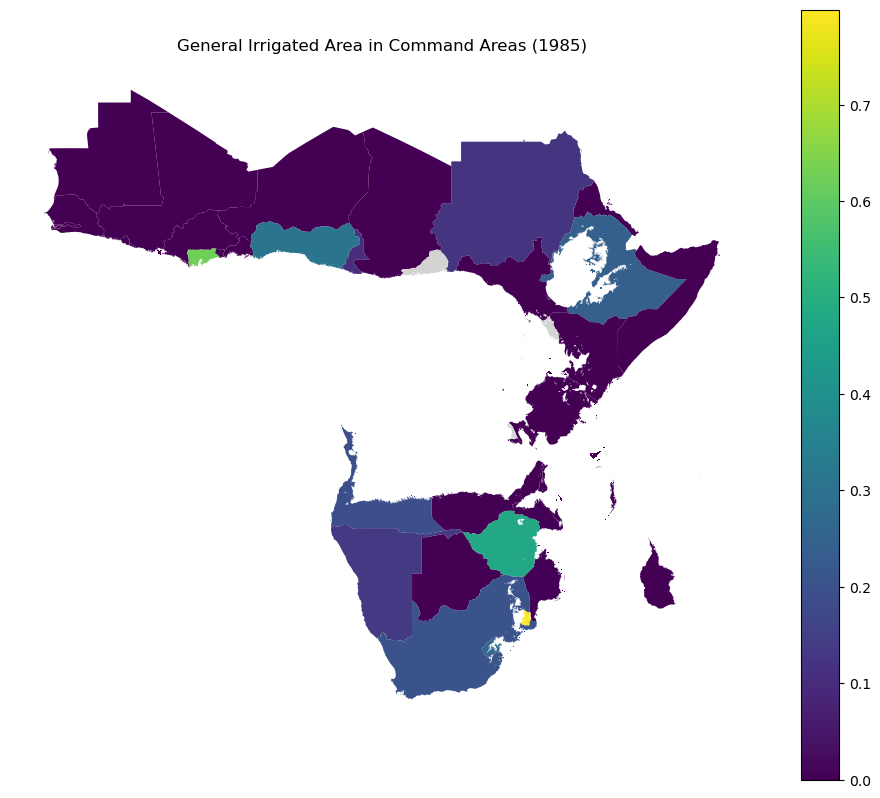

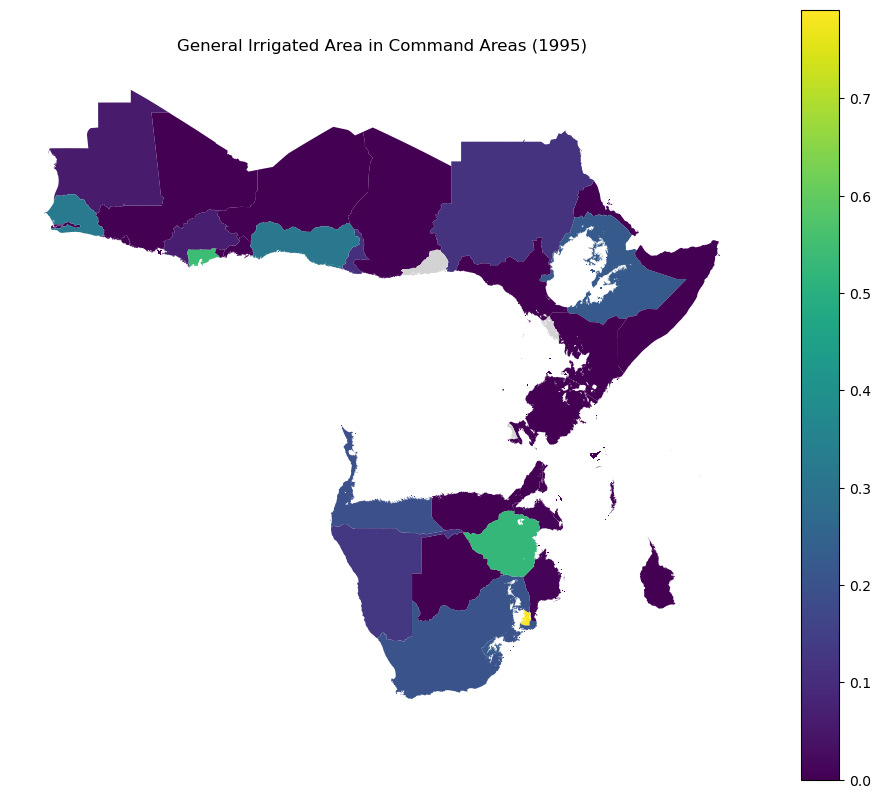

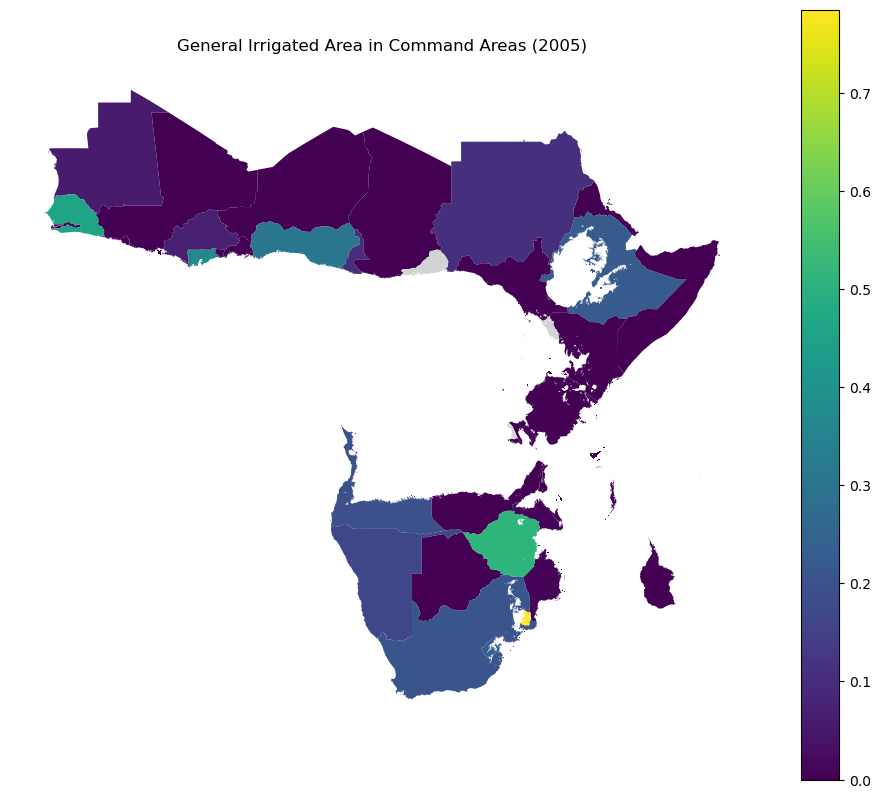

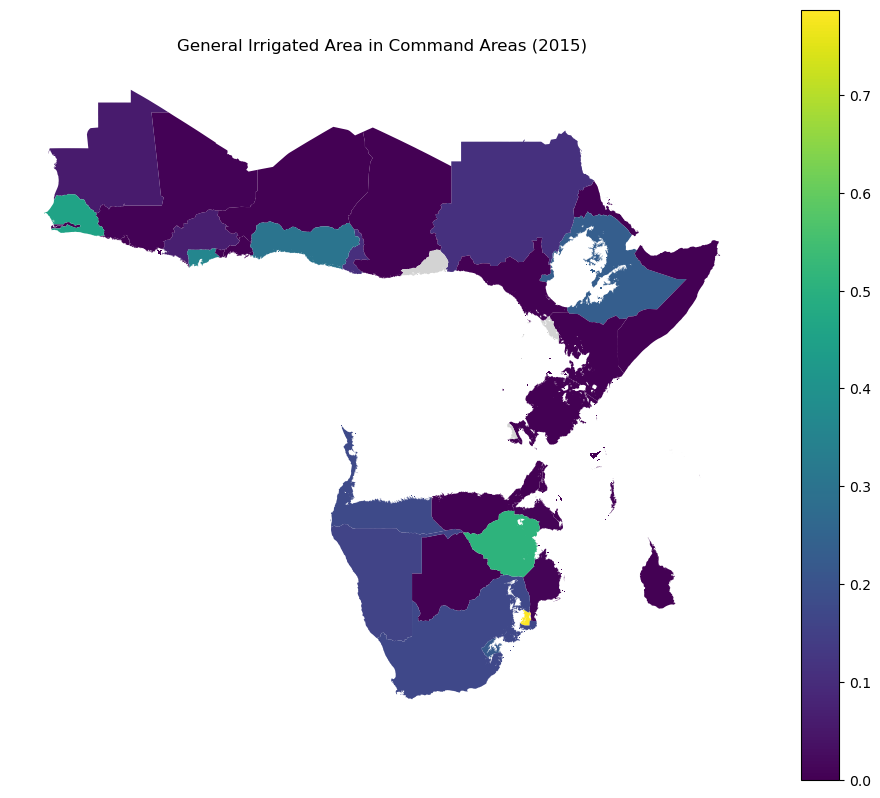

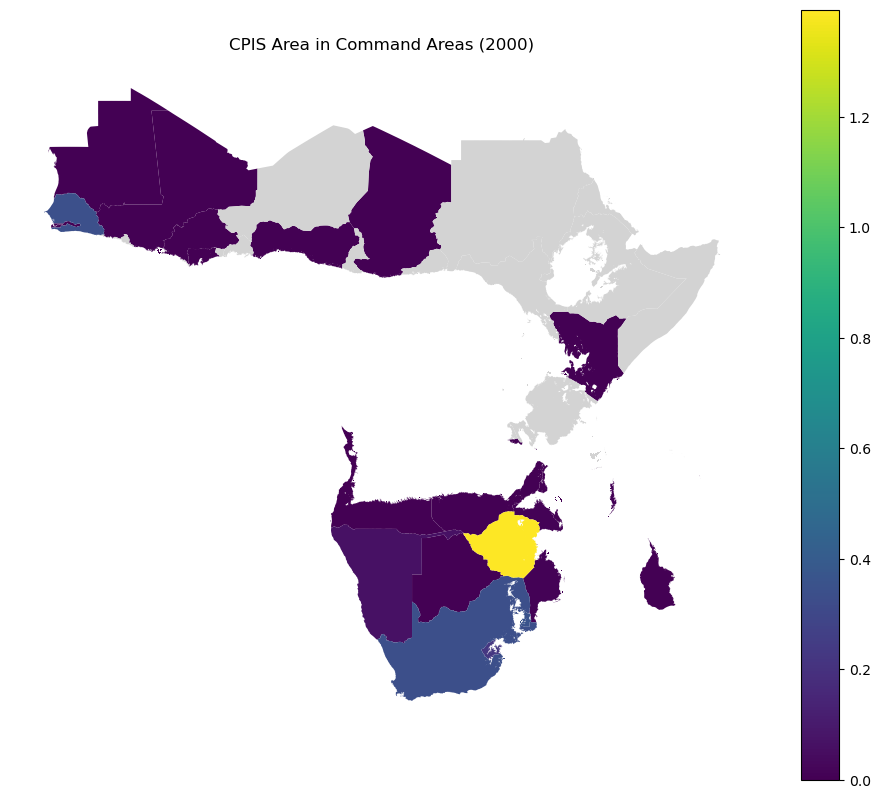

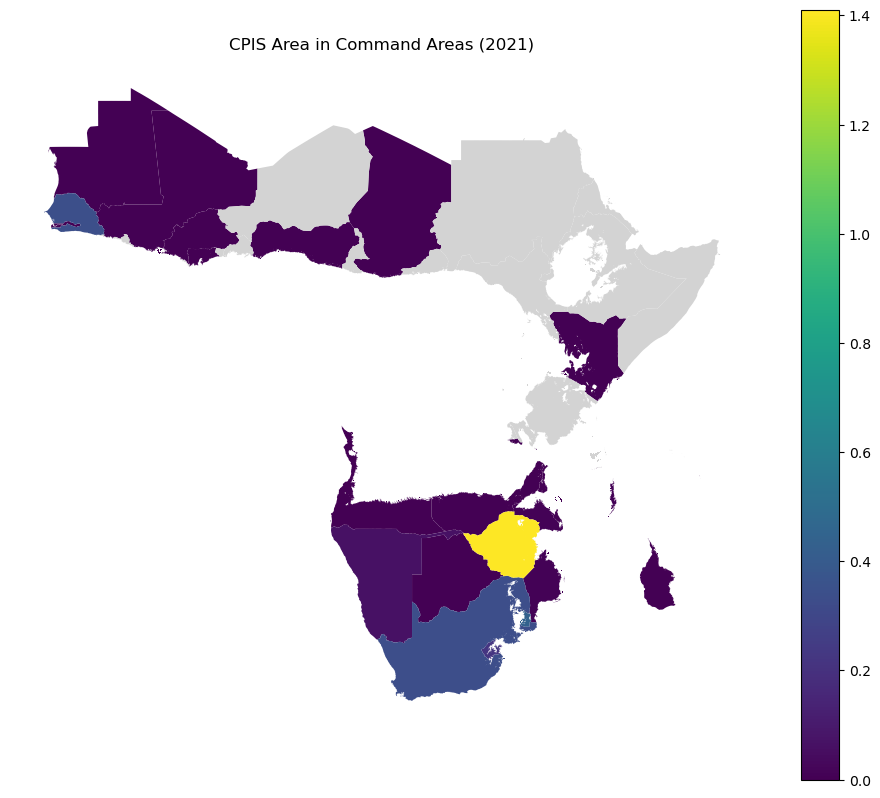

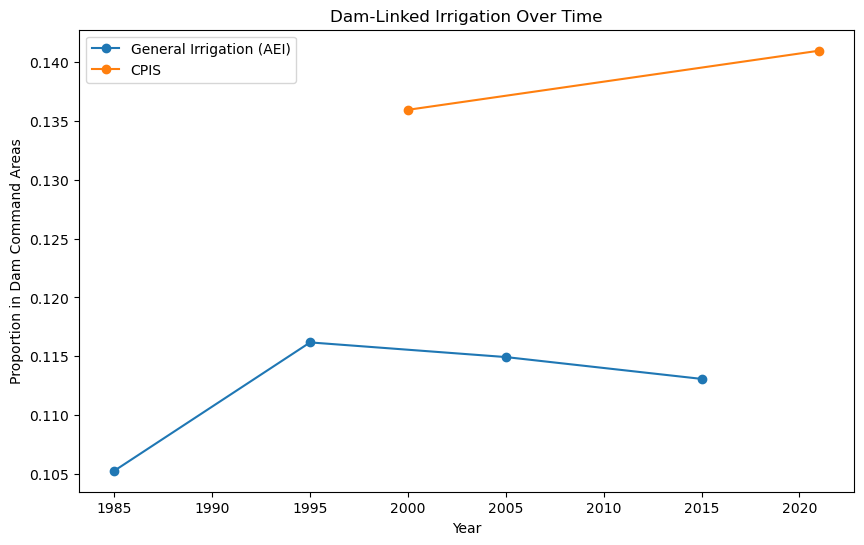

In [ ]:
# Maps
plot_all_maps(results_df_initial, ssa_arid_gdf, 'proportion_in_ca', label='General Irrigated Area')
plot_all_maps(results_df_cpis, ssa_arid_gdf, 'cpis_proportion_in_ca', label='CPIS Area')

# Line Plot
plot_combined_time_series(results_df_initial, results_df_cpis)
